               0         1         2         3         4         5         6   \
A[C>A]A  0.014436  0.005014  0.007352  0.024876  0.006122  0.011943  0.009791   
A[C>A]C  0.015251  0.004778  0.008233  0.024866  0.006282  0.012348  0.010197   
A[C>A]G  0.010967  0.004250  0.008096  0.024372  0.006075  0.012085  0.010615   
A[C>A]T  0.011095  0.004720  0.009251  0.027033  0.007219  0.013966  0.013258   
C[C>A]A  0.004692  0.113165  0.029130  0.007939  0.004443  0.009269  0.008288   
...           ...       ...       ...       ...       ...       ...       ...   
G[T>G]T  0.037820  0.011980  0.001932  0.009906  0.003884  0.012016  0.009934   
T[T>G]A  0.006401  0.004856  0.004204  0.007379  0.008387  0.007146  0.006998   
T[T>G]C  0.006053  0.004727  0.003535  0.006936  0.008346  0.006874  0.006475   
T[T>G]G  0.006535  0.005135  0.003088  0.007065  0.008665  0.007215  0.006562   
T[T>G]T  0.007459  0.005680  0.002803  0.007233  0.008834  0.007487  0.006764   

               7         8 

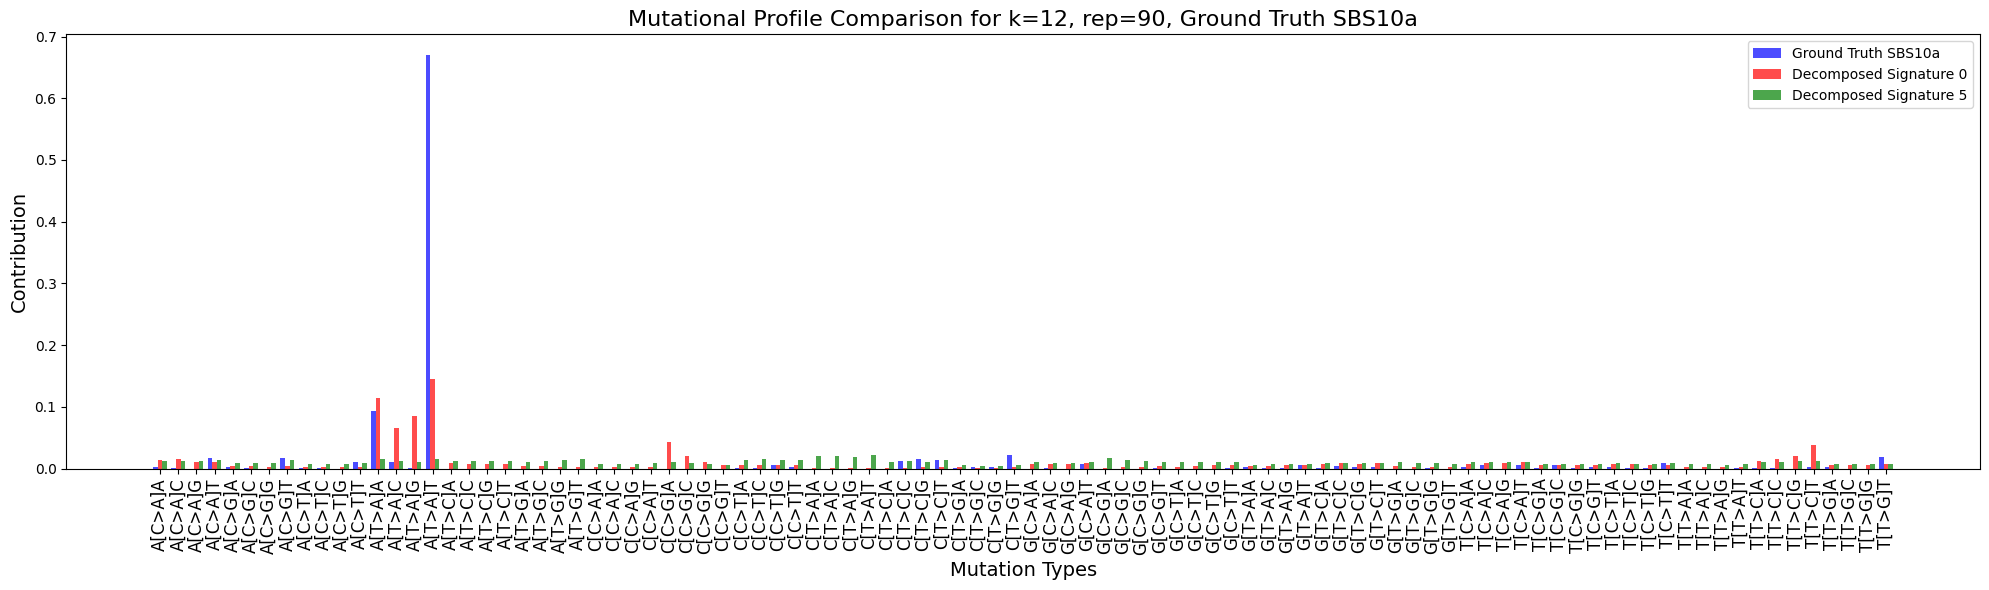

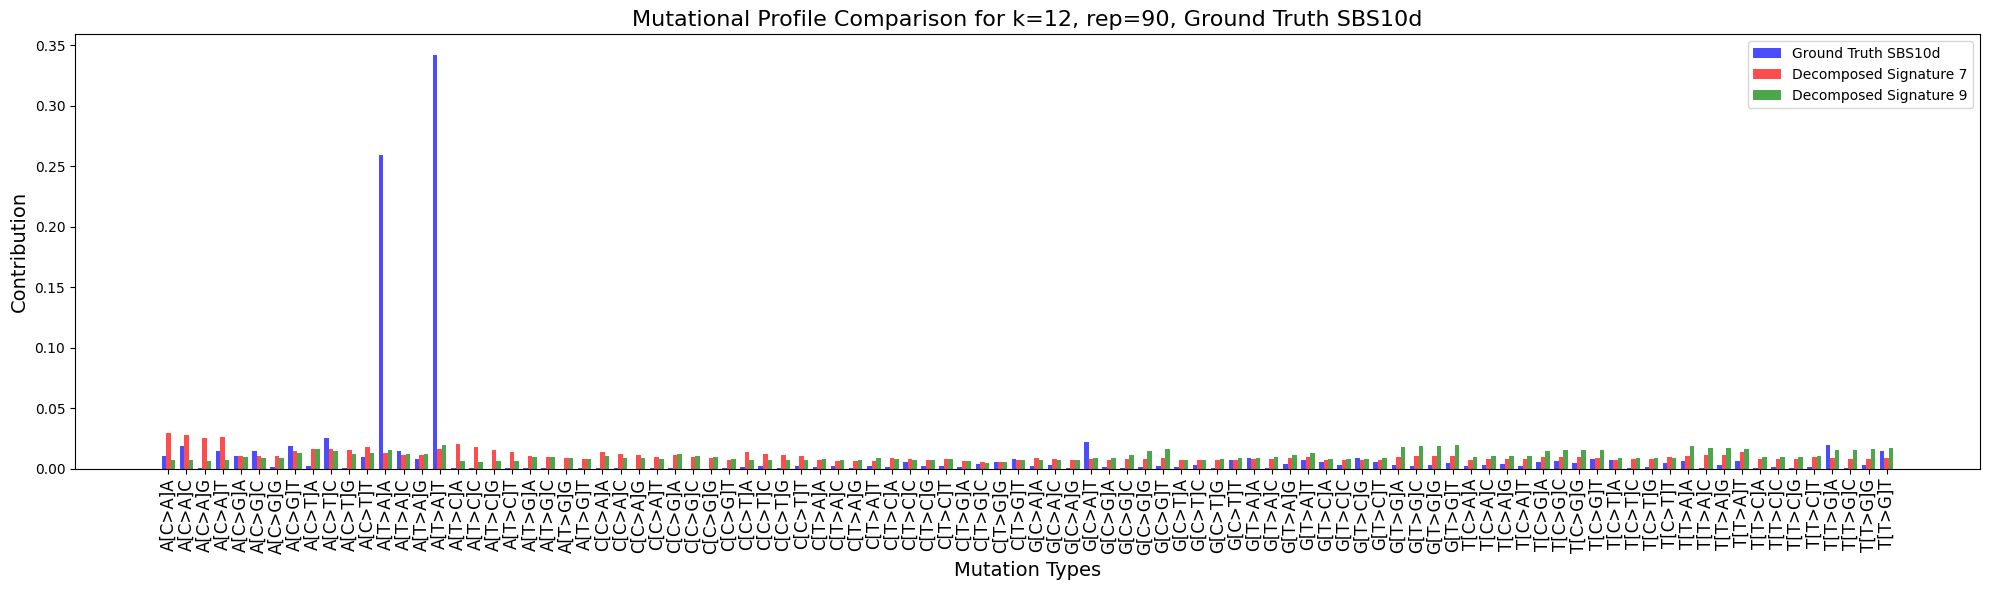

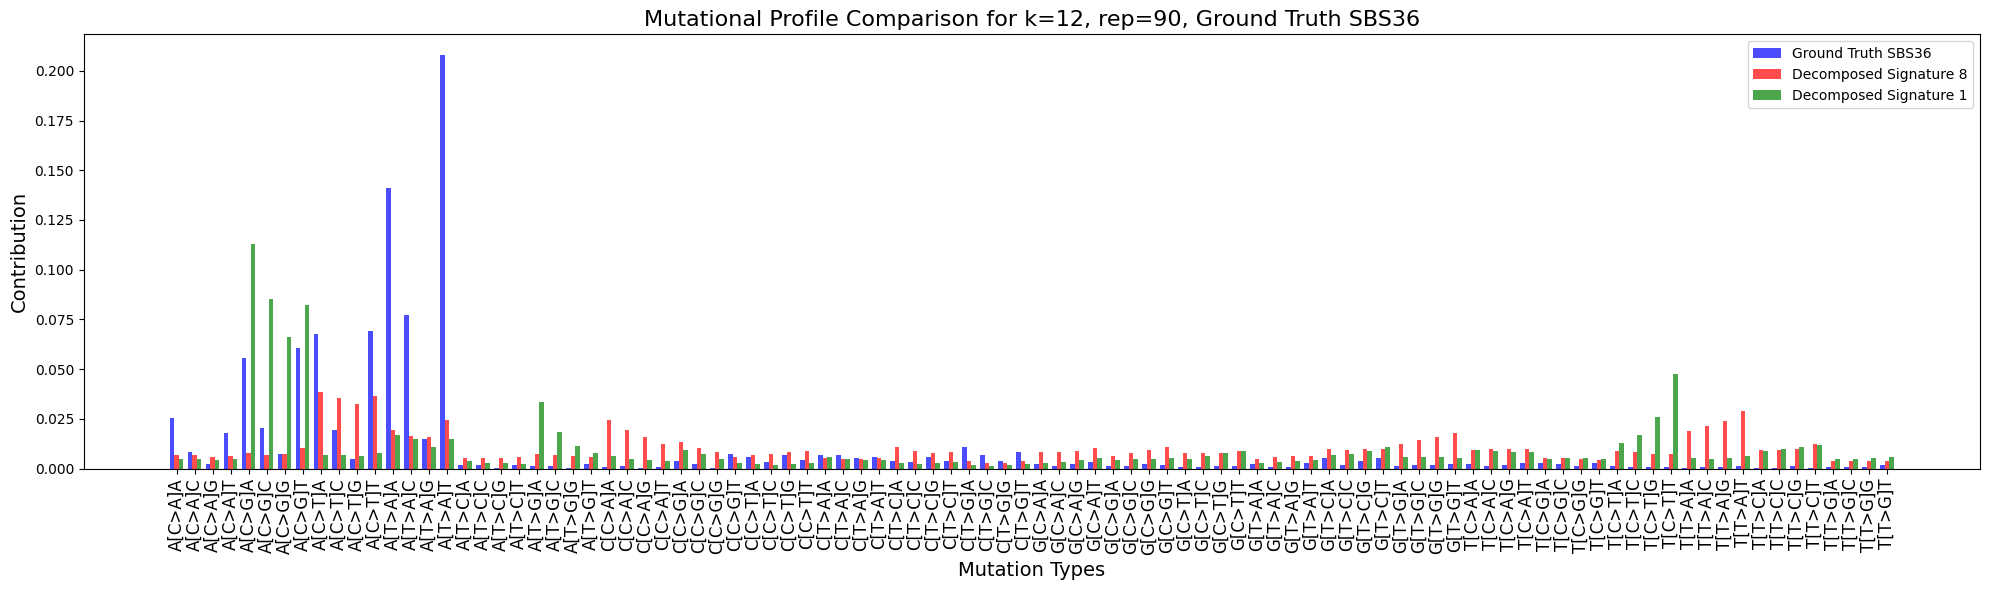

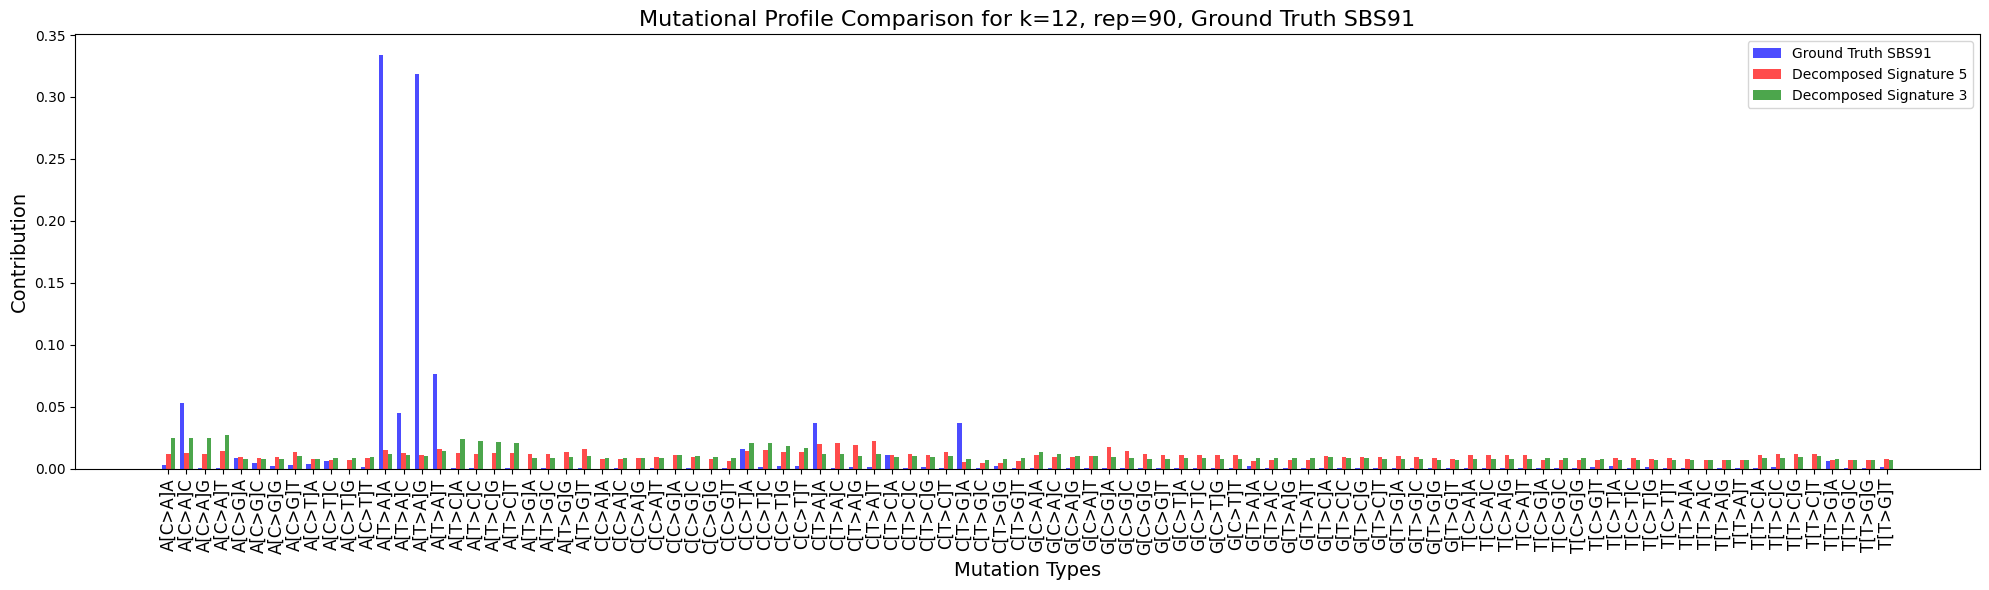

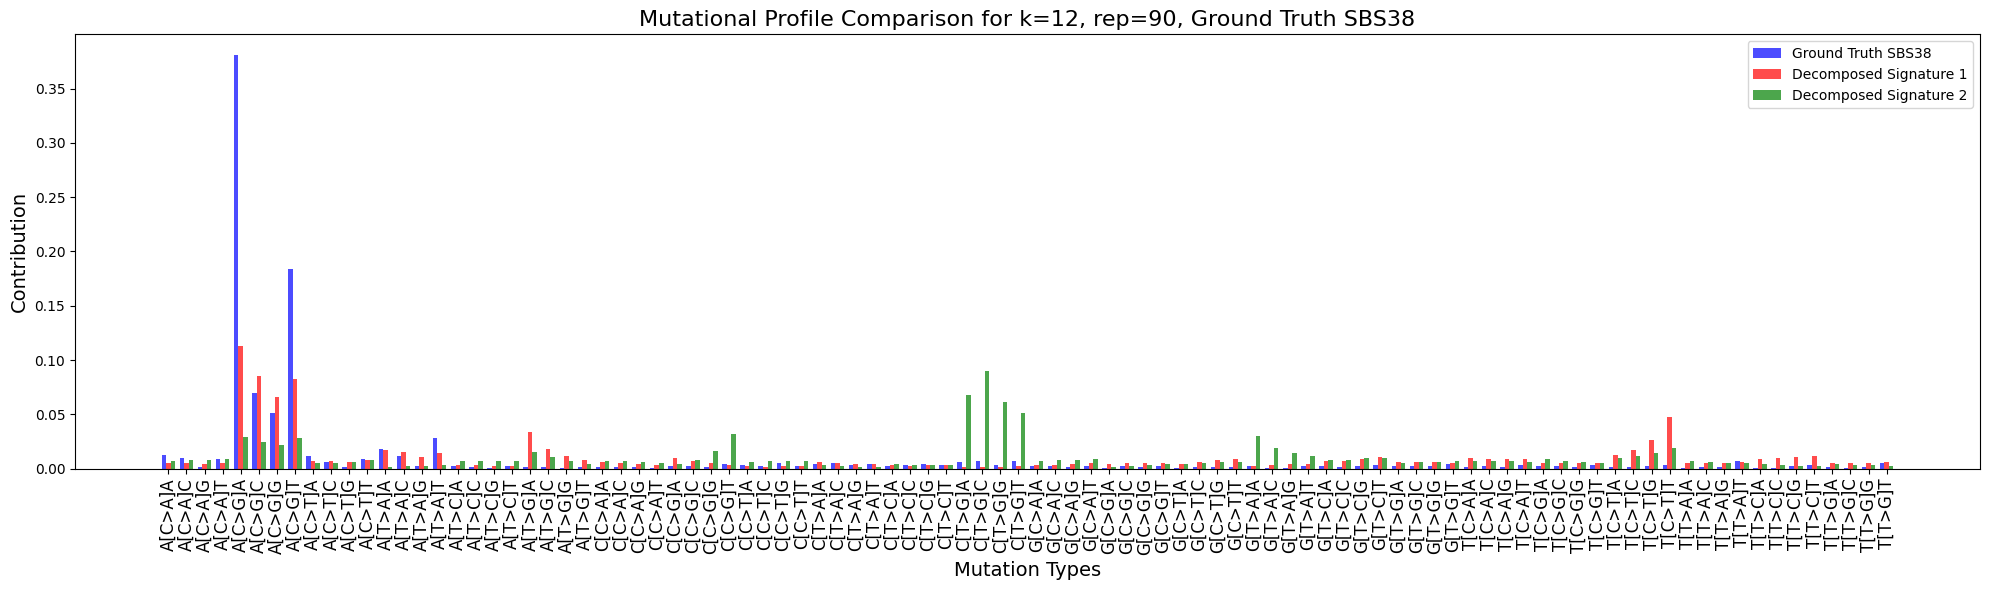

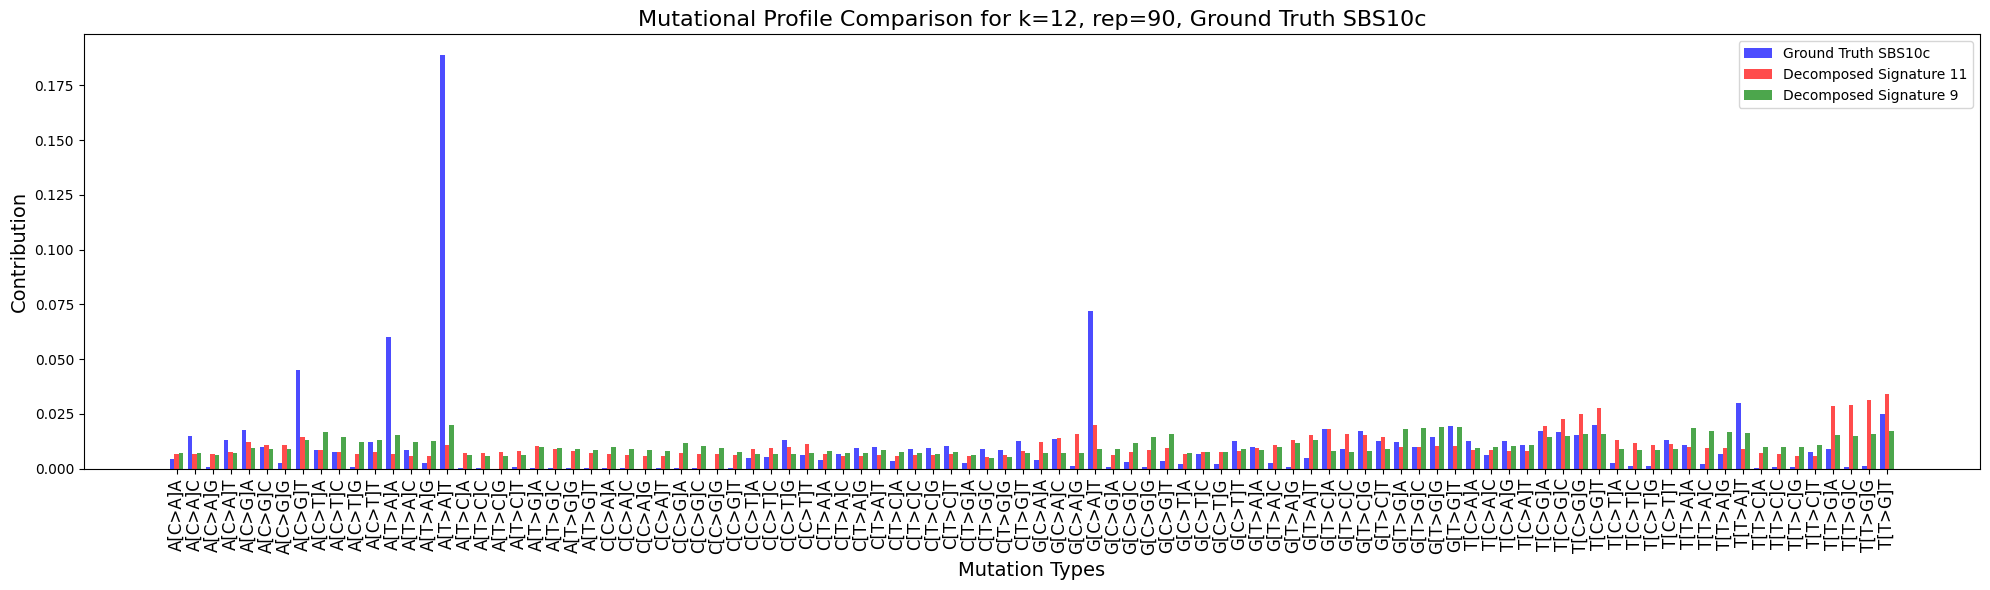

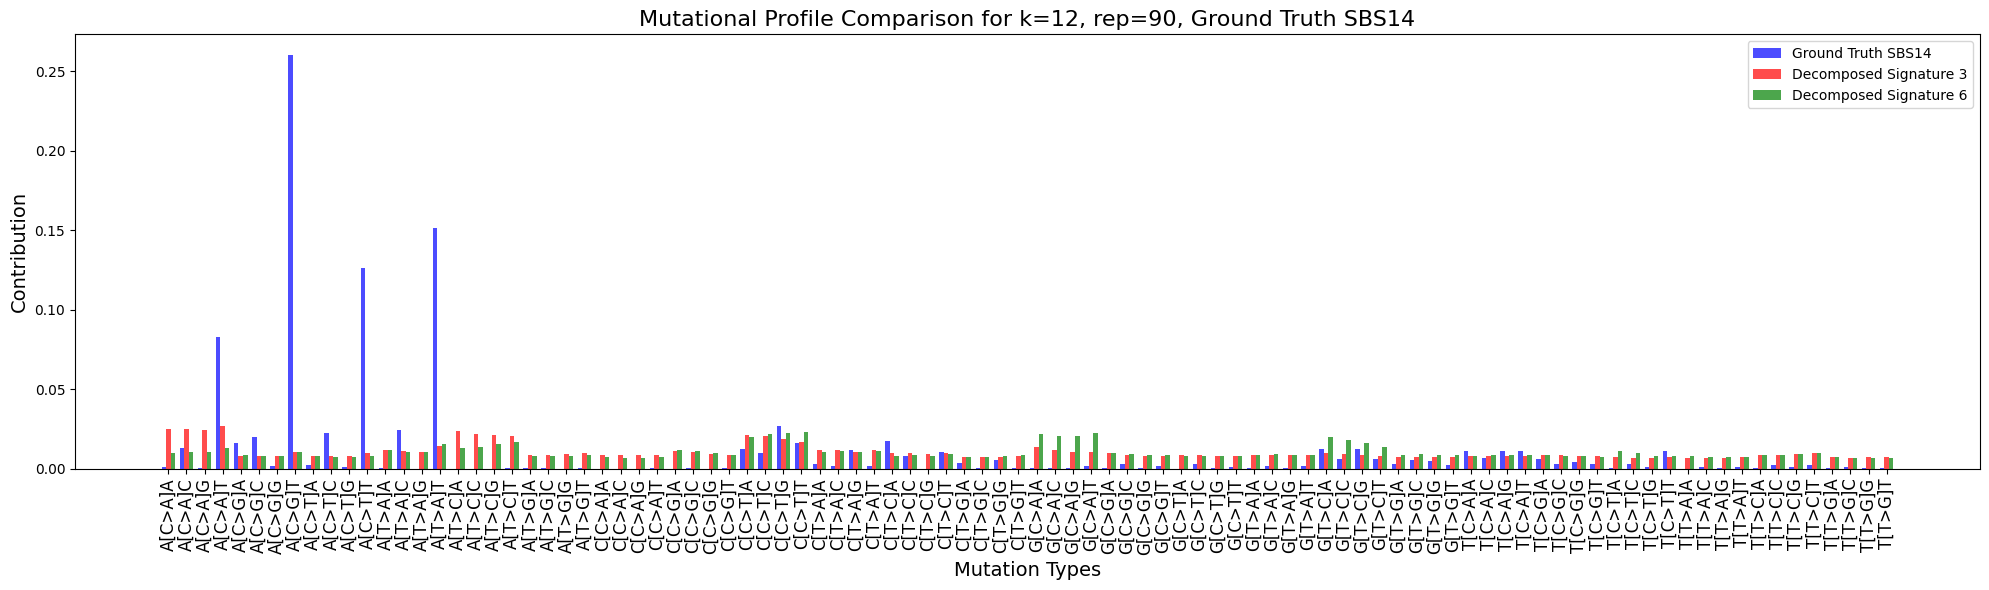

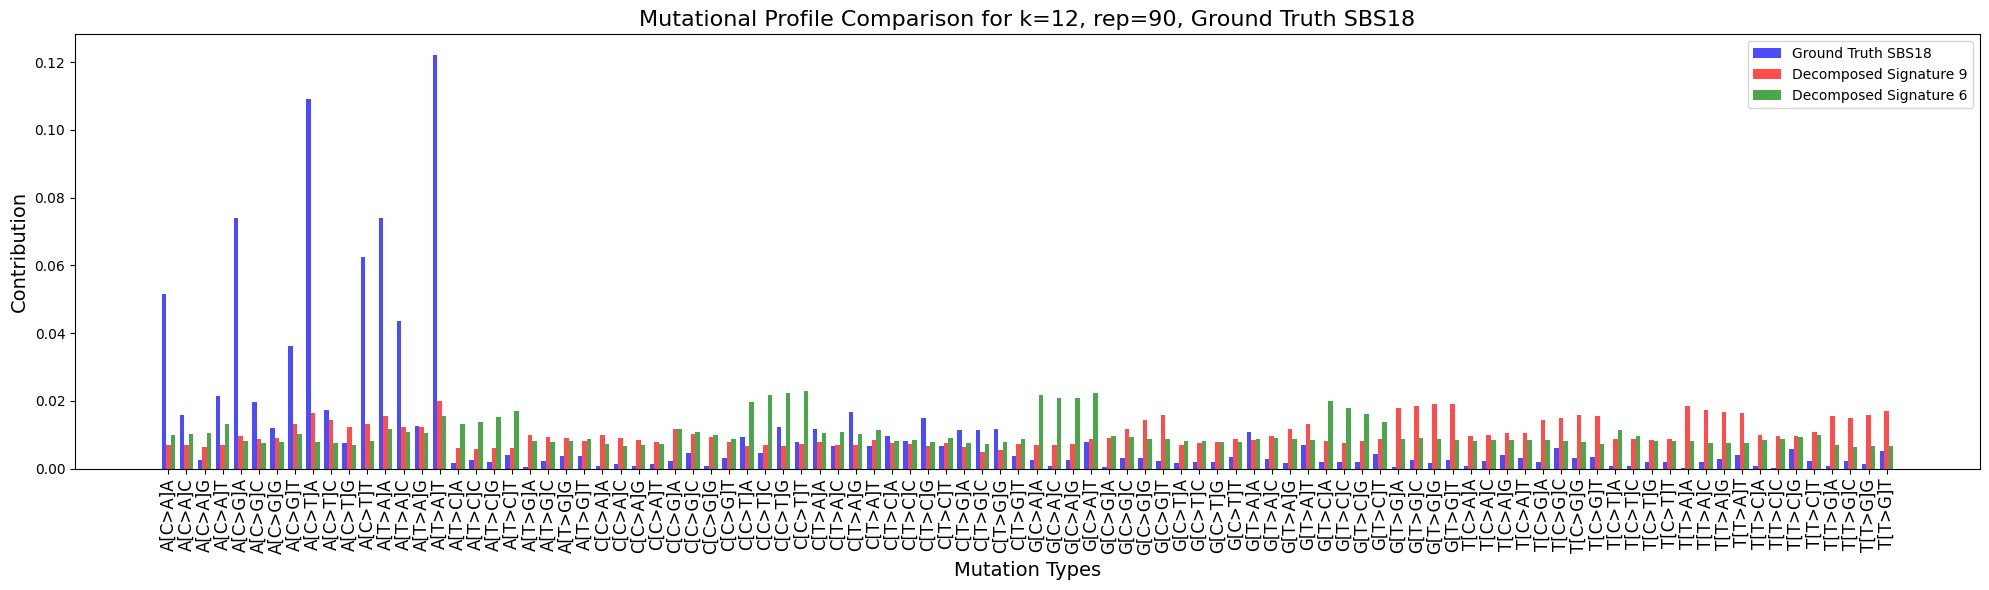

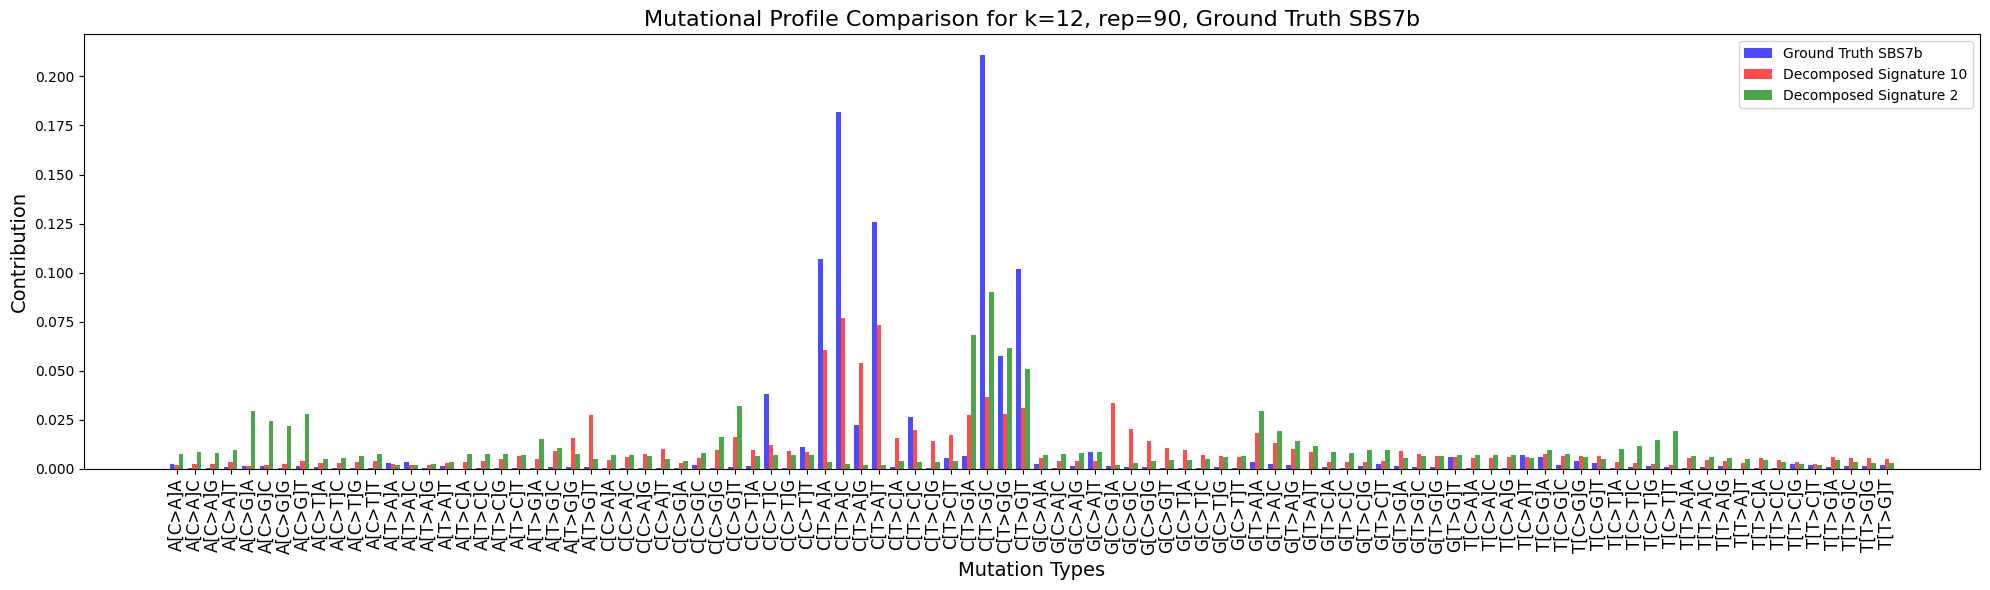

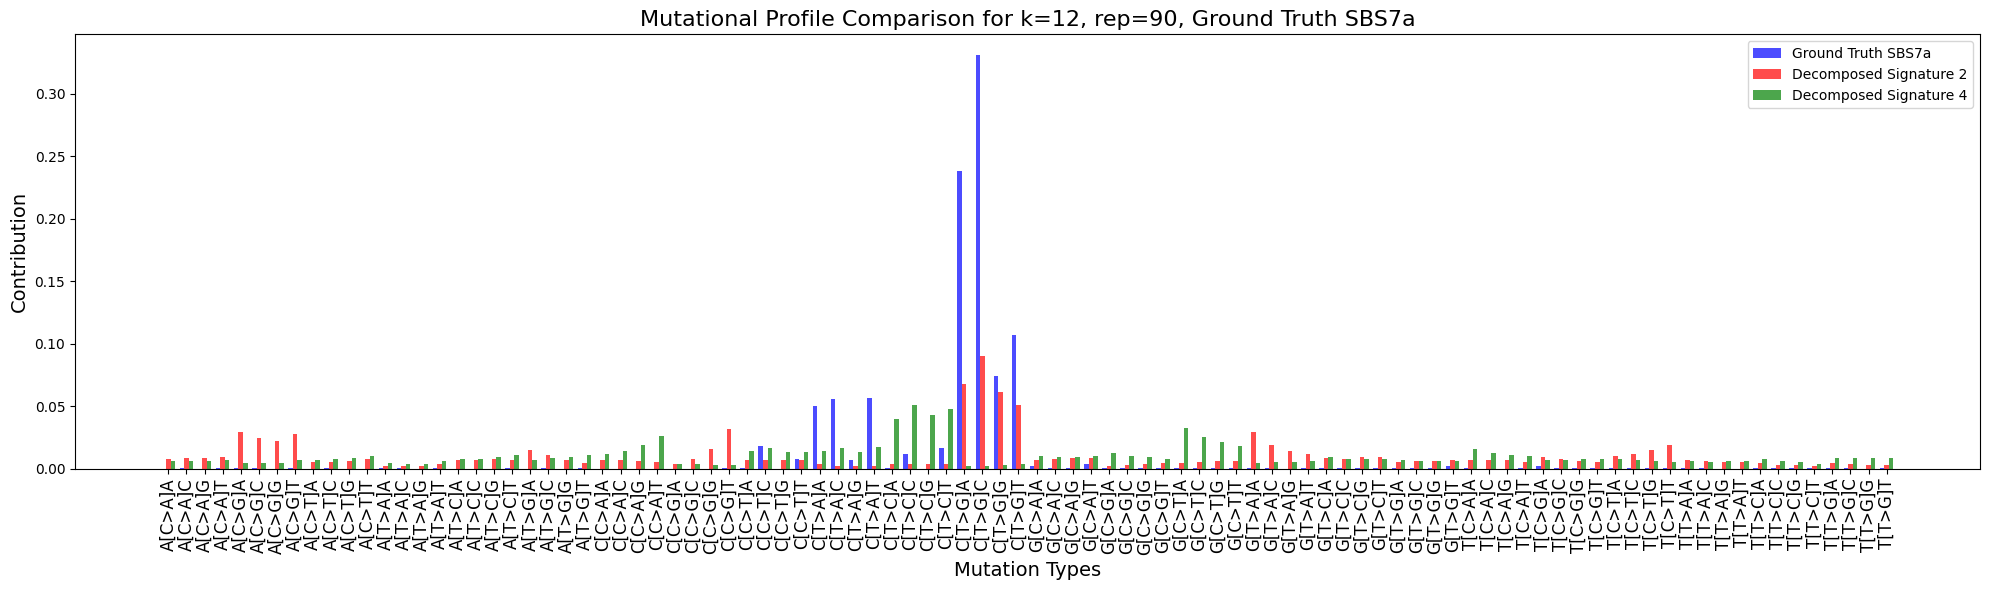

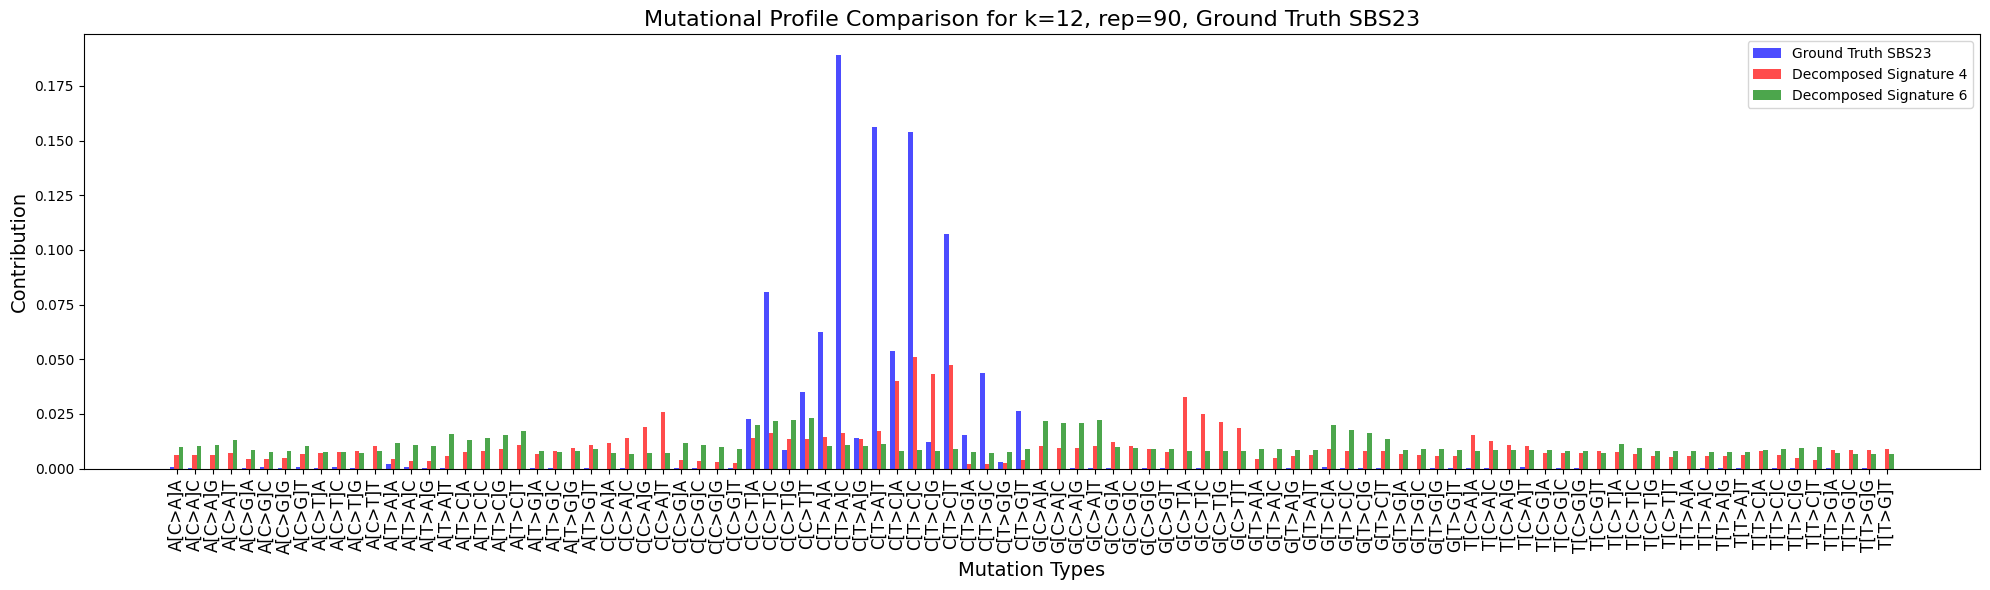

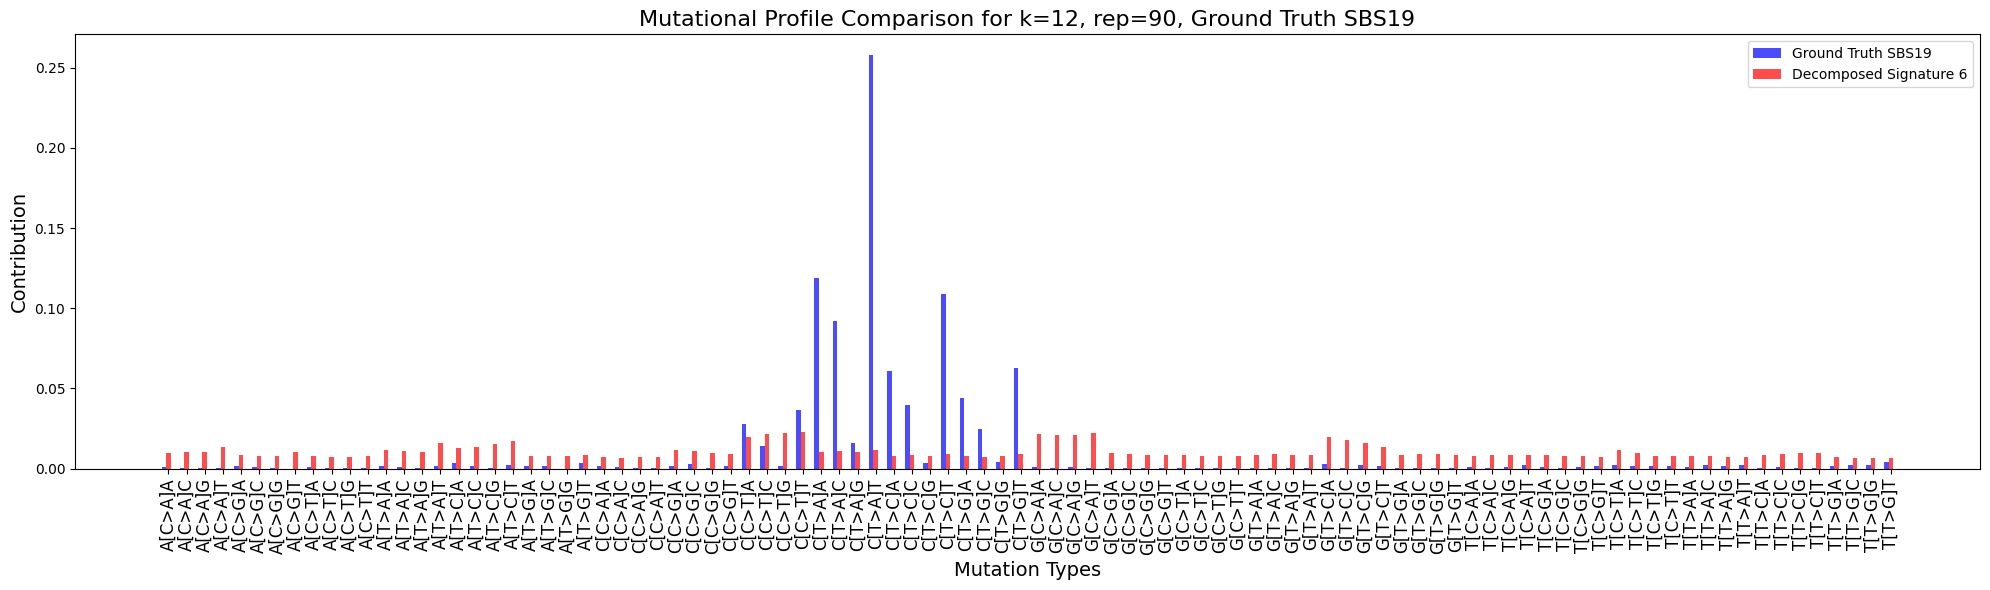

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr


def kullbeck_leibler_divergence(p, q):
    return np.sum(rel_entr(p, q))

# Parameters
M_path = 'simulated_data_01_15/s_15_n_0.06_c_500_2000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19.csv'
decomposed_matrices_folder = 'outputs/signature_matrices/s_15_n_0.04_c_500_2000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19'
ground_truth_path = 'cosmic_signatures/COSMIC_v3.4_SBS_GRCh37.txt'
k =12
rep = 90
W_path = f"{decomposed_matrices_folder}/D_k{k}_run{rep}.csv"

# Load data
M = pd.read_csv(M_path, header=None)
mutation_types = M.iloc[1:, 0].values  # Adjust indexing if necessary
ground_truth = pd.read_csv(ground_truth_path, sep='\t')
W = pd.read_csv(W_path,header=None)
W.index = mutation_types

for substring in ['[T>G]', '[T>C]', '[T>A]', '[C>T]', '[C>G]', '[C>A]']:
    matching_indices = W[W.index.str.contains(substring, regex=False)]
    ca = W.loc[matching_indices.index]
    W = W.drop(matching_indices.index)
    W = pd.concat([ca, W], axis=0)

    matching_indices = ground_truth[ground_truth['Type'].str.contains(substring, regex=False)]
    ca = ground_truth.loc[matching_indices.index]
    ground_truth = ground_truth.drop(matching_indices.index)
    ground_truth = pd.concat([ca, ground_truth], axis=0)

print(W)
matching_indices = ground_truth[ground_truth['Type'].str.contains(substring, regex=False)]
ca = ground_truth.loc[matching_indices.index]
ground_truth = ground_truth.drop(matching_indices.index)
ground_truth = pd.concat([ca, ground_truth], axis=0)
print(ground_truth)



# Define the list of ground truth signatures
ground_truth_signatures = [
    'SBS10a', 'SBS10d', 'SBS36', 'SBS91',
    'SBS38', 'SBS10c', 'SBS14', 'SBS18', 'SBS7b',
    'SBS7a', 'SBS23', 'SBS19'
]


# Iterate over each ground truth signature
used_decomposed_signatures = set()
used_ground_truth_signatures = set()
for signature in ground_truth_signatures:
    if signature in used_ground_truth_signatures:
        continue

    ground_truth_signature = ground_truth[signature].values
    ground_truth_signature /= ground_truth_signature.sum()  # Normalize

    # Initialize variables to find the two closest decomposed signatures
    min_wass_distance_1 = float('inf')
    min_wass_distance_2 = float('inf')
    selected_signature_index_1 = None
    selected_signature_index_2 = None

    # Compare with each decomposed signature
    for i in range(W.shape[1]):
        if i in used_decomposed_signatures:
            continue

        decomposed_signature = W.iloc[:, i].values
        decomposed_signature /= decomposed_signature.sum()  # Normalize
        wass_distance = np.linalg.norm(ground_truth_signature - decomposed_signature, ord=1)
        
        if wass_distance < min_wass_distance_1:
            min_wass_distance_2 = min_wass_distance_1
            selected_signature_index_2 = selected_signature_index_1
            min_wass_distance_1 = wass_distance
            selected_signature_index_1 = i
        elif wass_distance < min_wass_distance_2:
            min_wass_distance_2 = wass_distance
            selected_signature_index_2 = i

    if selected_signature_index_1 is not None:
        used_decomposed_signatures.add(selected_signature_index_1)
        used_ground_truth_signatures.add(signature)

        # Plot the ground truth signature and the two closest decomposed signatures
        plt.figure(figsize=(20, 6))
        bar_width = 0.25
        indices = np.arange(len(mutation_types))

        # Plot ground truth signature
        plt.bar(indices, ground_truth_signature, bar_width, label=f'Ground Truth {signature}', alpha=0.7, color='b')

        # Plot closest decomposed signature
        closest_decomposed_signature_1 = W.iloc[:, selected_signature_index_1].values
        closest_decomposed_signature_1 /= closest_decomposed_signature_1.sum()  # Normalize
        plt.bar(indices + bar_width, closest_decomposed_signature_1, bar_width, label=f'Decomposed Signature {selected_signature_index_1}', alpha=0.7, color='r')

        if selected_signature_index_2 is not None:
            closest_decomposed_signature_2 = W.iloc[:, selected_signature_index_2].values
            closest_decomposed_signature_2 /= closest_decomposed_signature_2.sum()  # Normalize
            plt.bar(indices + 2 * bar_width, closest_decomposed_signature_2, bar_width, label=f'Decomposed Signature {selected_signature_index_2}', alpha=0.7, color='g')

        plt.xlabel('Mutation Types', fontsize=14)
        plt.ylabel('Contribution', fontsize=14)
        plt.title(f'Mutational Profile Comparison for k={k}, rep={rep}, Ground Truth {signature}', fontsize=16)
        plt.xticks(indices + bar_width, mutation_types, rotation=90, fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

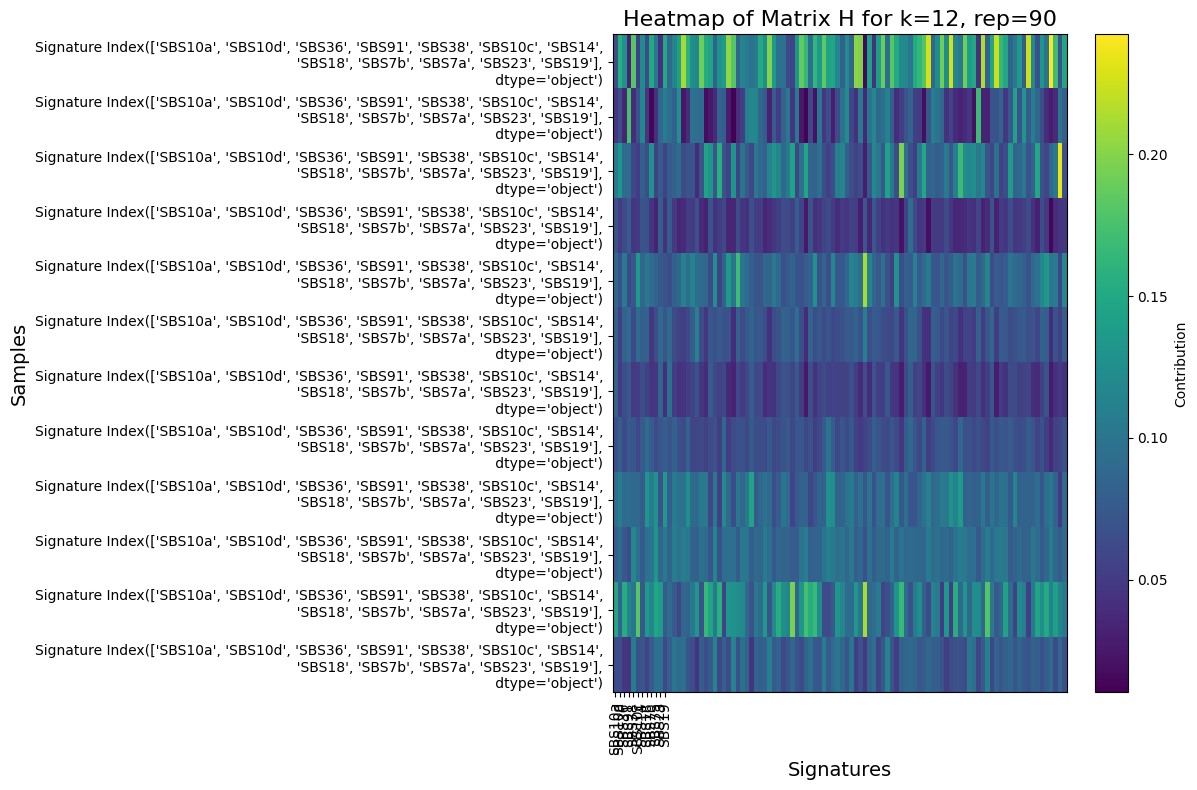

In [ ]:
# Plot matrix H
H_path = f"{decomposed_matrices_folder}/lambda_k{k}_run{rep}.csv"
H = pd.read_csv(H_path, header=None)
H.index = ground_truth_signatures

plt.figure(figsize=(12, 8))
plt.imshow(H, aspect='auto', cmap='viridis')
plt.colorbar(label='Contribution')
plt.xticks(ticks=np.arange(len(ground_truth_signatures)), labels=ground_truth_signatures, rotation=90)
plt.yticks(ticks=np.arange(H.shape[0]), labels=H.index.values)
plt.xlabel('Signatures', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.title(f'Heatmap of Matrix H for k={k}, rep={rep}', fontsize=16)
plt.tight_layout()
plt.show()